# Clinical Trials Data Processing

## Goal

- To get a basic data processing pipeline outlined 
- To get the results we need to build a MVP 
- To understand future steps for more advanced study p

## TODOS
- Compare results filtering with the number of results from the GUI
- Parse all studies into workable CSVs with certain attributes 
- Create a safe method for getting values from the JSON file withought killin the study 
- Add in objective flags for measurement types
- Get the P-Values with the other types
- Add in the demographics to the csv
- Look at the missed values and see if the studies are really missing data 


In [1]:
# I think we just need to get all the studies and filter out the ones with results manually 
# We can make a module for this later
# The conditions can be easily parsed but we need to bucket them -> maybe make a model for that??
# The demographics are the easiest to get out of this
# Effectiveness - this can be done by averaging the difference between placebo and results, thought we 
# first have to filter the studies that have a placebo 
#
# Fields to be 

In [197]:
import requests
import pandas as pd
import scipy.stats as stats 
import nltk
import seaborn as sns

nltk.download('wordnet')
API_BASE_URL='https://clinicaltrials.gov/api/query'
EXAMPLE_DRUG='hydrocodone'

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/porterhunley/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


### Interfacing with ClinicalTrials.gov
- TODO: need to get all the studies not just the ones in a certain range 
- It's also worth noting that we can download all of this data

In [3]:
# First a basic API interface

def get_studies_by_expression(expression):
    r = requests.get(API_BASE_URL + '/full_studies?expr={expr}&min_rnk=1&max_rnk=99&fmt=json'
                     .format(expr=expression))
    return r.json()

def get_conditions_for_drug(drug):
    r = requests.get(API_BASE_URL + '/field_values?expr={drug}&field=ConditionAncestorTerm&fmt=json'
                     .format(drug=drug))
    
    return r.json()

In [4]:
def get_all_studies(expr, results=True):
    og_length = 99
    studies = []
    count = 0
    while (og_length >= 99):
        r = requests.get(API_BASE_URL + '/full_studies?expr={expr}&min_rnk={min_rank}&max_rnk={max_rank}&fmt=json'
                         .format(expr=expr, min_rank=count*99 + 1, max_rank=(count*99+1)+98))
        og_length = len(r.json()['FullStudiesResponse'].get('FullStudies', []))
        new_studies = r.json()['FullStudiesResponse'].get('FullStudies', [{'Study': []}])
        studies += list(filter(lambda x: 'ResultsSection' in x['Study'] and 'OutcomeMeasuresModule' in x['Study']['ResultsSection'], new_studies))
        count+=1
        
    return studies


## Conditions

### Consolidate the Conditions Data

- Need to get all the conditions in a formatted dataframe to parse the other results

- TODO: the AncestorConditions are too broad and the normal conditions are too specific -> we need our own 
method for this


In [27]:
raw_conditions_dict = get_conditions_for_drug('gabapentin') 

In [28]:
condition_field_values = raw_conditions_dict['FieldValuesResponse']['FieldValues']

In [29]:
parsable = {'Conditions': [], 'NStudies': []}
for value in condition_field_values:
    parsable['Conditions'].append(value['FieldValue'])
    parsable['NStudies'].append(value['NStudiesFoundWithValue'])

conditionsDf = pd.DataFrame.from_dict(parsable).sort_values('NStudies', ascending=False)
conditionsDf

,Conditions,NStudies
183,Neurologic Manifestations,200
176,Nervous System Diseases,173
198,Pain,155
203,Pathologic Processes,122
184,Neuromuscular Diseases,85
...,...,...
120,Infertility,1
121,"Infertility, Male",1
122,Inflammatory Bowel Diseases,1
123,Intellectual Disability,1


### Exploratory Statistics 
- Let's get a better feel for the conditions here 

In [30]:
conditionsDf.head(20)


,Conditions,NStudies
183,Neurologic Manifestations,200
176,Nervous System Diseases,173
198,Pain,155
203,Pathologic Processes,122
184,Neuromuscular Diseases,85
150,Mental Disorders,82
213,Postoperative Complications,68
207,Peripheral Nervous System Diseases,62
160,Musculoskeletal Diseases,44
246,Sleep Wake Disorders,40


<AxesSubplot:>

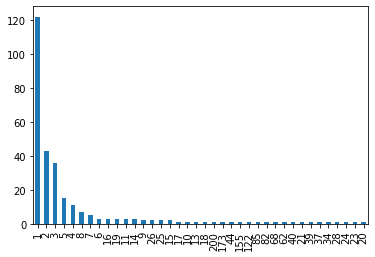

In [31]:
import matplotlib.pyplot as plt

conditionsDf['NStudies'].value_counts().plot.bar()

In [32]:
# We need to get a cutoff value for what conditions are going to be listed 
# The value should be percentage based to account for the differing study values for each drug
# Maybe the conditions that add up to 50% of the data or something 
# Actually let's just take top 5 - this is a problem for the medical people

conditionsDf.sum()['NStudies']

2189

In [33]:
count = 0
curr_sum = 0
total_sum = conditionsDf.sum()['NStudies']
for i in range(len(conditionsDf)):
    if curr_sum / total_sum > .1:
        break
    
    curr_sum += conditionsDf['NStudies'][i]
    count += 1


## Study Processing

- Filter out useless studies san results 
- Parse out useful values from the tree: place
- Create a dataframe for the other aspects of drug 

In [8]:
# Get all studies for all conditions for a given drug
# studies = []
# for condition in conditionsDf[0:3]['Conditions'].tolist():
#     print(EXAMPLE_DRUG + ' AND AREA[ConditionAncestorTerm]{}'.format(condition))
#     studies += get_all_studies(EXAMPLE_DRUG + ' AND AREA[ConditionAncestorTerm]{}'.format(condition))
    

### Parsing data
- Need to reduce the attrition rate for all the studies
- Let's get all the following into a csv -> a function for each

In [141]:
# Get all studies relating to the example drug 
studies = get_all_studies(EXAMPLE_DRUG)
len(studies)

70

### Create Tables
- Studies
- Groups
- Outcomes
- Measures

We need a good relational model to analyze this data fully

In [142]:
def create_studies_table(studies):
    buffer = {
        'study_id': [], 'name': [], 'drug': [], 'conditions': [], 
        'verified_date': [], 'responsible_party': [], 'type': [], 'description': [],
        'interventions': []
              
         }
    for i, study in enumerate(studies):


        buffer['drug'].append(EXAMPLE_DRUG)
        try:
            buffer['study_id'].append(study['Study']['ProtocolSection']['IdentificationModule']['NCTId'])
        except KeyError as e:
            buffer['study_id'].append('NA')

        try:
            buffer['name'].append(study['Study']['ProtocolSection']['IdentificationModule']['OfficialTitle'])
        except KeyError as e:
            buffer['name'].append('NA')

        try:
            buffer['verified_date'].append(study['Study']['ProtocolSection']['StatusModule']['StatusVerifiedDate'])
        except KeryError as e:
            buffer['verified_date'].append('NA')

        try:
            buffer['responsible_party'].append(study['Study']['ProtocolSection']['SponsorCollaboratorsModule']['ResponsibleParty'])
        except KeyError as e:
            buffer['responsible_party'].append('NA')

        try: 
            buffer['conditions'].append(study['Study']['ProtocolSection']['ConditionsModule']['ConditionList']['Condition'])
        except KeyError as e:
            buffer['conditions'].append('NA')

        try:
            buffer['type'].append(study['Study']['ProtocolSection']['DesignModule']['DesignInfo']['DesignInterventionModel'])
        except KeyError as e:
            buffer['type'].append('NA')
            
        try:
            buffer['description'].append(study['Study']['ProtocolSection']['DescriptionModule']['DetailedDescription'])
        except KeyError as e:
            buffer['description'].append('NA')
            
        try: 
            buffer['interventions'].append([x.get('InterventionMeshTerm', 'NA') for x in study['Study']['DerivedSection']['InterventionBrowseModule']['InterventionMeshList']['InterventionMesh']])
        except KeyError as e:
            buffer['interventions'].append([])
    
    return buffer
studies_df = pd.DataFrame.from_dict(create_studies_table(studies))
studies_df.head()

,study_id,name,drug,conditions,verified_date,responsible_party,type,description,interventions
0,NCT01517295,Evaluating the Pharmacokinetic Profile of Hydr...,hydrocodone,[Chronic Pain],June 2016,{'ResponsiblePartyType': 'Sponsor'},Parallel Assignment,Hydrocodone combinations are the most commonly...,[Hydrocodone]
1,NCT01922739,"A 6-Month, Open-Label, Extension Study to Eval...",hydrocodone,[Low Back Pain],April 2017,{'ResponsiblePartyType': 'Sponsor'},Single Group Assignment,Eligible patients from Study 3103 (NCT01789970...,[Hydrocodone]
2,NCT01223365,"A 12-Month, Open-Label Study to Evaluate the L...",hydrocodone,[Chronic Pain],May 2017,{'ResponsiblePartyType': 'Sponsor'},Single Group Assignment,"This was a Phase 3, open-label, nonrandomized ...",[Hydrocodone]
3,NCT01400139,"An Open-label, Multicenter Study to Assess the...",hydrocodone,[Chronic Nonmalignant and Nonneuropathic Pain],March 2020,{'ResponsiblePartyType': 'Sponsor'},Single Group Assignment,NA,[Hydrocodone]
4,NCT01789970,"A 12-Week, Randomized, Double-Blind, Placebo-C...",hydrocodone,[Low Back Pain],June 2017,{'ResponsiblePartyType': 'Sponsor'},Parallel Assignment,The study consisted of a screening period of a...,[Hydrocodone]


In [143]:
studies_df[studies_df['interventions'].apply(len) == 0]

,study_id,name,drug,conditions,verified_date,responsible_party,type,description,interventions
23,NCT01759446,"A Single-center, Randomized, Double-blind, Act...",hydrocodone,[Opioid-Related Disorders],August 2018,{'ResponsiblePartyType': 'Sponsor'},Crossover Assignment,NA,[]
29,NCT01011634,"A Double Blinded, Placebo-controlled Randomize...",hydrocodone,"[Undesired Intrauterine Pregnancy, First Trime...",May 2013,{'ResponsiblePartyType': 'Sponsor'},Parallel Assignment,Approximately 50% of pregnancies in the United...,[]
33,NCT01153503,Ultrasound-guided Transversus Abdominis Plane ...,hydrocodone,[Post Operative Pain],January 2018,{'ResponsiblePartyType': 'Principal Investigat...,Parallel Assignment,Patients undergoing abdominal hysterectomy (n=...,[]
37,NCT02712554,"A Randomized, Double-Blind, Placebo and Active...",hydrocodone,"[Pain, Nausea, Vomiting]",October 2019,{'ResponsiblePartyType': 'Sponsor'},Crossover Assignment,The purpose of this study is to assess the abu...,[]
44,NCT02431793,EHR-Based Medication Complete Communication St...,hydrocodone,"[Opioid Use, Unspecified]",September 2019,{'ResponsiblePartyType': 'Principal Investigat...,Parallel Assignment,Research has shown that patients frequently le...,[]
48,NCT01696188,Comparison of In-Plane vs. Out-of-Plane Ultras...,hydrocodone,[Shoulder Pain],October 2015,{'ResponsiblePartyType': 'Sponsor'},Single Group Assignment,Interscalene nerve block is an effective metho...,[]
56,NCT00703729,The Effectiveness of Simultaneous Intermittent...,hydrocodone,"[Postoperative Pain, Shoulder Pain]",August 2015,{'ResponsiblePartyType': 'Sponsor'},Parallel Assignment,NA,[]
57,NCT01620528,"A Randomized, Double-Blind, Placebo-Controlled...",hydrocodone,[Endometriosis],March 2017,{'ResponsiblePartyType': 'Sponsor'},Parallel Assignment,"This is a Phase 3, multicenter, double-blind, ...",[]
59,NCT01931670,"A Randomized, Double-Blind, Placebo-Controlled...",hydrocodone,[Endometriosis],March 2018,{'ResponsiblePartyType': 'Sponsor'},Parallel Assignment,The study consists of 4 periods: 1) Washout Pe...,[]
61,NCT01760954,Extension Study to Evaluate the Long-Term Safe...,hydrocodone,[Endometriosis],March 2018,{'ResponsiblePartyType': 'Sponsor'},Parallel Assignment,"This is a Phase 3 multicenter, double blind ra...",[]


#### Groups Table
The control or placebo group that gets nothing 
- Name
- Study
- Id
- Number of participants 
- Description

In [144]:
def create_groups_table(studies): # The groups in the baseline -> this might end up badly 
    groups_df = { 
        'name': [],
        'study_id': [],
        'id': [],
        'description': [],
        'participants': []
    }
    parts = []
    for study in studies:
        study_id = study['Study']['ProtocolSection']['IdentificationModule']['NCTId']
        groups = []
        denoms = []
        try: 
            groups = study['Study']['ResultsSection']['BaselineCharacteristicsModule']['BaselineGroupList']['BaselineGroup']
        except KeyError as e:
            groups = []
            
        for group in groups:

            groups_df['name'].append(group.get('BaselineGroupTitle', 'NA'))
            groups_df['study_id'].append(study_id)
            groups_df['id'].append(group.get('BaselineGroupId', 'NA'))
            groups_df['description'].append(group.get('BaselineGroupDescription'))
                
        try:
            denoms = study['Study']['ResultsSection']['BaselineCharacteristicsModule']['BaselineDenomList']['BaselineDenom']
        except KeyError as e:
            denoms = []
            
        participants = list(filter(lambda x: x.get('BaselineDenomUnits', 'NA') == 'Participants', denoms))
        for participant in participants[0]['BaselineDenomCountList']['BaselineDenomCount']:
            groups_df['participants'].append(int(participant['BaselineDenomCountValue']))
    
    return groups_df, parts
        
groups = pd.DataFrame.from_dict(create_groups_table(studies)[0])
groups.head()

,name,study_id,id,description,participants
0,Group 1,NCT01517295,BG000,"Blood will be drawn at 0, 1, 3, and 5 hours af...",16
1,Group 2,NCT01517295,BG001,"Blood will be drawn at 0, 2, 4, and 6 hours af...",14
2,Total,NCT01517295,BG002,Total of all reporting groups,30
3,Hydrocodone ER - Opioid Naive,NCT01922739,BG000,Participants were administered hydrocodone ER ...,109
4,Hydrocodone ER - Opioid Experienced,NCT01922739,BG001,Participants were administered hydrocodone ER ...,73


#### Measures Table
- Study Id
- title
- Type 
- Description
- Disperision param
- Measure Param
- Units

In [145]:
def get_outcome_modules(studies):
    outcome_modules = []
    for study in studies:
        if 'OutcomeMeasuresModule' in study['Study']['ResultsSection']:
            outcome_modules.append(study['Study']['ResultsSection']['OutcomeMeasuresModule'])
            continue 
        print('No Results: ', study['Study']['ProtocolSection']['IdentificationModule']['OfficialTitle'])
        
    return outcome_modules

def create_measures_table(studies):
    outcome_modules = get_outcome_modules(studies)
    df = {
        'study_id': [],
        'measure': [],
        'type': [],
        'description': [],
        'dispersion_param': [],
        'measure_param': [],
        'units': []
    }
    
    for i, module in enumerate(outcome_modules):
        study_id = studies[i]['Study']['ProtocolSection']['IdentificationModule']['NCTId']
        for measure in module['OutcomeMeasureList']['OutcomeMeasure']:
            df['type'].append(measure.get('OutcomeMeasureType', 'NA'))
            df['measure'].append(measure.get('OutcomeMeasureTitle', 'NA'))
            df['description'].append(measure.get('OutcomeMeasureDescription', 'NA'))
            df['measure_param'].append(measure.get('OutcomeMeasureParamType', 'NA'))
            df['dispersion_param'].append(measure.get('OutcomeMeasureDispersionType', 'NA'))
            df['units'].append(measure.get('OutcomeMeasureUnitOfMeasure', 'NA'))
            df['study_id'].append(study_id)
            
    return df 

measures = pd.DataFrame.from_dict(create_measures_table(studies)).drop_duplicates(['study_id', 'measure'])
measures.head()

,study_id,measure,type,description,dispersion_param,measure_param,units
0,NCT01517295,Peak Plasma Concentration of Hydromorphone,Primary,Determine the plasma pharmacokinetic profile o...,Standard Deviation,Mean,ng/mL
1,NCT01517295,Correlation of Plasma PK of Hydrocodone,Secondary,Correlate the plasma pharmacokinetic profile o...,NA,NA,NA
2,NCT01517295,Peak Urine Concentration of Hydromorphone,Secondary,Analyze the urine concentration of hydromorphone,Standard Deviation,Mean,ng/mL
3,NCT01922739,Participants With Adverse Events,Primary,An adverse event (AE) was defined in the proto...,NA,Count of Participants,Participants
4,NCT01922739,Participants With Potentially Clinically Signi...,Primary,Data represents participants with potentially ...,NA,Count of Participants,Participants


In [146]:
measures[measures['type'] == 'Primary']['units'].value_counts()

Participants                                57
units on a scale                            27
h*ng/mL                                      9
percentage of participants                   8
scores on a scale                            8
Visual Analog Score (0-100)                  8
dollars                                      6
score on a scale                             5
ng/mL                                        5
NA                                           4
minutes                                      4
pharmacy claims                              4
days                                         4
mg                                           3
ng*hr/mL                                     3
hours                                        3
Percentage of participants                   2
ratio                                        2
visits                                       2
participants                                 2
bDMARD                                       2
Units on a sc

#### Outcomes Table
- Study_id
- Group_id
- Type
- Title
- Measure
- Unit
- Time
- Dispersion
- Upper 
- Lower
- Value 


In [147]:
'''
We need to create disjoint tables :( 
'''
    
# def make_outcomes_map(measure):
#     mp = {}
#     for group in measure.get('OutcomeClassList', {'OutcomeClass': []})['OutcomeClass']:
#         mp['classTitle'] = group.get('OutcomeClassTitle', 'NA')
        
#         for cat in group.get('OutcomeCategoryList', {'OutcomeCategory': []})['OutcomeCategory']:
#             for outcome in cat['OutcomeMeasurementList']['OutcomeMeasurement']:
#                 mp[outcome['OutcomeMeasurementGroupId']] = outcome
#     return mp
                
                
def create_outcomes_table(studies):
    outcome_modules = get_outcome_modules(studies)
    admin_df = {
        'study_id': [],
        'group_id': [],
        'measure': [],
        'title': [],
        'description': [],
    }
    
    outcome_df = {
        'study_id': [],
        'group_id': [],
        'measure': [],
        'title': [],
        'value': [],
        'dispersion': [],
        'upper': [],
        'lower': [],
        'participants': []
    }
    
    for i, module in enumerate(outcome_modules):
        study_id = studies[i]['Study']['ProtocolSection']['IdentificationModule']['NCTId']
        for measure in module['OutcomeMeasureList']['OutcomeMeasure']:
            try:
                overall_group_to_no = {}
                for denom in measure.get('OutcomeDenomList', {'OutcomeDenom': []})['OutcomeDenom']:
                    if denom.get('OutcomeDenomUnits', 'NA') == 'Participants':
                        for count in denom.get('OutcomeDenomCountList', {'OutcomeDenomCount': []})['OutcomeDenomCount']:
                            overall_group_to_no[count['OutcomeDenomCountGroupId']] = count['OutcomeDenomCountValue']
                                
                for admin in measure.get('OutcomeGroupList', {'OutcomeGroup': []})['OutcomeGroup']:
                    admin_df['study_id'].append(study_id)
                    admin_df['group_id'].append(admin.get('OutcomeGroupId', 'NA'))
                    admin_df['measure'].append(measure.get('OutcomeMeasureTitle', 'NA'))
                    admin_df['title'].append(admin.get('OutcomeGroupTitle', 'NA'))
                    admin_df['description'].append(admin.get('OutcomeGroupDescription', 'NA'))
                    
                # Sometimes the participants are just listed one time before all the others - not just in the class
                for group in measure.get('OutcomeClassList', {'OutcomeClass': []})['OutcomeClass']:
    
                    group_to_no = {}
                    for denom in group.get('OutcomeClassDenomList', {'OutcomeClassDenom': []})['OutcomeClassDenom']:
                        for count in denom.get('OutcomeClassDenomCountList', {'OutcomeClassDenomCount': []})['OutcomeClassDenomCount']:
                            group_to_no[count['OutcomeClassDenomCountGroupId']] = count['OutcomeClassDenomCountValue']

                    for cat in group.get('OutcomeCategoryList', {'OutcomeCategory': []})['OutcomeCategory']:
                        for outcome in cat['OutcomeMeasurementList']['OutcomeMeasurement']:
                            outcome_df['study_id'].append(study_id)
                            outcome_df['group_id'].append(outcome.get('OutcomeMeasurementGroupId', 'NA'))
                            outcome_df['measure'].append(measure.get('OutcomeMeasureTitle', 'NA'))
                            outcome_df['value'].append(outcome.get('OutcomeMeasurementValue', 'NA'))
                            outcome_df['dispersion'].append(outcome.get('OutcomeMeasurementSpread', 'NA'))
                            outcome_df['upper'].append(outcome.get('OutcomeMeasurementUpperLimit', 'NA'))
                            outcome_df['lower'].append(outcome.get('OutcomeMeasurementLowerLimit', 'NA'))
                            outcome_df['participants'].append(group_to_no.get(outcome.get('OutcomeMeasurementGroupId', 'NA'), None) or overall_group_to_no.get(outcome.get('OutcomeMeasurementGroupId', 'NA'), 'NA'))
                            outcome_df['title'].append(group.get('OutcomeClassTitle', 'NA'))
                        
                    
            except KeyError as e:
                print(e)
                continue
                
    return (admin_df, outcome_df)
        
admin_df, outcome_df = create_outcomes_table(studies)
administrations = pd.DataFrame.from_dict(admin_df)
outcomes = pd.DataFrame.from_dict(outcome_df)

In [148]:
outcomes

,study_id,group_id,measure,title,value,dispersion,upper,lower,participants
0,NCT01517295,OG000,Peak Plasma Concentration of Hydromorphone,Hour 0,0,0,NA,NA,16
1,NCT01517295,OG001,Peak Plasma Concentration of Hydromorphone,Hour 0,0,0,NA,NA,14
2,NCT01517295,OG000,Peak Plasma Concentration of Hydromorphone,Hour 1,0,0,NA,NA,16
3,NCT01517295,OG001,Peak Plasma Concentration of Hydromorphone,Hour 1,NA,NA,NA,NA,14
4,NCT01517295,OG000,Peak Plasma Concentration of Hydromorphone,Hour 2,NA,NA,NA,NA,16
...,...,...,...,...,...,...,...,...,...
6241,NCT01179191,OG000,Number of Participants With Urine Drug Test Re...,NA,85,NA,NA,NA,351
6242,NCT01179191,OG000,Number of Participants With Urine Drug Test Re...,Baseline (n= 684),51,NA,NA,NA,684
6243,NCT01179191,OG000,Number of Participants With Urine Drug Test Re...,Visit 3 (n= 351),24,NA,NA,NA,684
6244,NCT01179191,OG000,Number of Participants With Greater Than or Eq...,Baseline (n= 684),122,NA,NA,NA,684


In [149]:
administrations

,study_id,group_id,measure,title,description
0,NCT01517295,OG000,Peak Plasma Concentration of Hydromorphone,Group 1,"Blood will be drawn at 0, 1, 3, and 5 hours af..."
1,NCT01517295,OG001,Peak Plasma Concentration of Hydromorphone,Group 2,"Blood will be drawn at 0, 2, 4, and 6 hours af..."
2,NCT01517295,OG000,Correlation of Plasma PK of Hydrocodone,Group 1,"Blood will be drawn at 0, 1, 3, and 5 hours af..."
3,NCT01517295,OG001,Correlation of Plasma PK of Hydrocodone,Group 2,"Blood will be drawn at 0, 2, 4, and 6 hours af..."
4,NCT01517295,OG000,Peak Urine Concentration of Hydromorphone,Group 1,"Blood will be drawn at 0, 1, 3, and 5 hours af..."
...,...,...,...,...,...
1933,NCT01179191,OG000,Number of Participants With Aberrant Behaviors,EMBEDA,EMBEDA (morphine sulfate/naltrexone hydrochlor...
1934,NCT01179191,OG000,Number of Participants With Abnormal Urine Dru...,EMBEDA,EMBEDA (morphine sulfate/naltrexone hydrochlor...
1935,NCT01179191,OG000,Number of Participants With Urine Drug Test Re...,EMBEDA,EMBEDA (morphine sulfate/naltrexone hydrochlor...
1936,NCT01179191,OG000,Number of Participants With Urine Drug Test Re...,EMBEDA,EMBEDA (morphine sulfate/naltrexone hydrochlor...


In [150]:
# Now we actually need to add in the doses
# This is going to be tricky as the groups have sepperate doses
#Put it all together
units_map = {
    'milligram': 'mg',
    'kilogram': 'kg',
    'gram': 'g'
            }
def clean_doses_map(doses_map, hitlist):
    units = []
    nums_map = {}
    for num in doses_map:
        unit = []
        for word in doses_map[num]:
            if word in hitlist:
                unit.append(units_map[word] if word in units_map else word)
            elif '/' in word:
                unit.append('/'.join(filter(lambda x: x in hitlist, word.split('/'))))
        nums_map[num] = ''.join(unit).replace('per', '/')
    return nums_map

def check_trailings_for_measures(trailings, hitlist):
    mask = []
    for trailing in trailings:
        flag = False
        for word in trailing:
            if (word in hitlist) or ('/' in word):
                flag = True
        mask.append(flag)

    return mask

def get_nums_trailings(trailings, nums, hitlist):
    mask = check_trailings_for_measures(trailings, hitlist)
    return {nums[i]:trailings[i] for i in range(len(nums)) if mask[i]}
        
doses_hit_list = ['mg', 'g', 'kg', 'milligram', 'kilogram', 'gram', 'per']
doses_hit_list += [x+'/' for x in doses_hit_list]

stemmer = nltk.stem.PorterStemmer()
def apply_to_nested_list(nested_list, func):
    for i, lst in enumerate(nested_list):
        lst = [func(x) for x in lst]
        nested_list[i] = lst
    return nested_list

def get_numbers(string):
    nums= []
    curr_num= []
    for char in string:
        if char.isdigit():
            curr_num.append(char)
        elif curr_num:
            nums.append(int(''.join(curr_num)))
            curr_num = []
            
    return nums

def get_trailing_words(string, nums):
    trailings = []
    for num in nums:
        trailings.append([x.replace('.', '').replace('(','').replace(')','') for x in string.split(str(num))[1].split()[0:3]])
    return trailings

def get_doses(string): #Typically the string is the description
    nums = get_numbers(string)
    trailings = get_trailing_words(string, nums)
    stemmed = apply_to_nested_list(trailings, stemmer.stem)
    return clean_doses_map(get_nums_trailings(stemmed, nums, doses_hit_list), doses_hit_list)
    

administrations['dose'] = administrations['description'].apply(get_doses)
administrations

,study_id,group_id,measure,title,description,dose
0,NCT01517295,OG000,Peak Plasma Concentration of Hydromorphone,Group 1,"Blood will be drawn at 0, 1, 3, and 5 hours af...",{}
1,NCT01517295,OG001,Peak Plasma Concentration of Hydromorphone,Group 2,"Blood will be drawn at 0, 2, 4, and 6 hours af...",{}
2,NCT01517295,OG000,Correlation of Plasma PK of Hydrocodone,Group 1,"Blood will be drawn at 0, 1, 3, and 5 hours af...",{}
3,NCT01517295,OG001,Correlation of Plasma PK of Hydrocodone,Group 2,"Blood will be drawn at 0, 2, 4, and 6 hours af...",{}
4,NCT01517295,OG000,Peak Urine Concentration of Hydromorphone,Group 1,"Blood will be drawn at 0, 1, 3, and 5 hours af...",{}
...,...,...,...,...,...,...
1933,NCT01179191,OG000,Number of Participants With Aberrant Behaviors,EMBEDA,EMBEDA (morphine sulfate/naltrexone hydrochlor...,{}
1934,NCT01179191,OG000,Number of Participants With Abnormal Urine Dru...,EMBEDA,EMBEDA (morphine sulfate/naltrexone hydrochlor...,{}
1935,NCT01179191,OG000,Number of Participants With Urine Drug Test Re...,EMBEDA,EMBEDA (morphine sulfate/naltrexone hydrochlor...,{}
1936,NCT01179191,OG000,Number of Participants With Urine Drug Test Re...,EMBEDA,EMBEDA (morphine sulfate/naltrexone hydrochlor...,{}


### Create Statistics 
- This is an interesting task because some of the studies have their own stats which we probably want to trust??

We need to bubble up the stats from the bottom, this means that each measure needs it's own results, then
we can interperate all the results on a higher level with the study

Generally we need some stats rows for each measure since we need to retrieve the ones that may or may not be a part of
the study

#### Stats table 
- Get the analysis from the existing measures if there is any 

In [151]:
def create_analytics_table(studies):
    outcome_modules = get_outcome_modules(studies)
    df = {
        'study_id': [],
        'measure': [],
        'groups': [],
        'description': [], # may or may not be the outcome title
        'method': [],
        'param_type': [],
        'fromStudy': [],
        'pval': [],
        'group_titles': []
    }
    
    for i, module in enumerate(outcome_modules):
        study_id = studies[i]['Study']['ProtocolSection']['IdentificationModule']['NCTId']
        for measure in module['OutcomeMeasureList']['OutcomeMeasure']:
            group_to_title = {}
            for group in measure.get('OutcomeGroupList', {'OutcomeGroup': []})['OutcomeGroup']:
                if group['OutcomeGroupId'] not in group_to_title:
                    group_to_title[group['OutcomeGroupId']] = 'NA'
                group_to_title[group['OutcomeGroupId']] = group.get('OutcomeGroupTitle', 'NA')
                    
            measure_title = measure.get('OutcomeMeasureTitle', 'NA')
            for stat in measure.get('OutcomeAnalysisList', {'OutcomeAnalysis': []})['OutcomeAnalysis']:
                df['study_id'].append(study_id)
                df['measure'].append(measure_title)
                df['groups'].append(stat.get('OutcomeAnalysisGroupIdList', {'OutcomeAnalysisGroupId': []})['OutcomeAnalysisGroupId'])
                df['description'].append(stat.get('OutcomeAnalysisGroupDescription', 'NA'))
                df['method'].append(stat.get('OutcomeAnalysisStatisticalMethod', 'NA'))
                df['param_type'].append(stat.get('OutcomeAnalysisParamType', 'NA'))
                df['fromStudy'].append(True)
                df['pval'].append(stat.get('OutcomeAnalysisPValue', 'NA'))
                df['group_titles'].append(dict([(g, group_to_title.get(g, 'NA')) for g in stat.get('OutcomeAnalysisGroupIdList', {'OutcomeAnalysisGroupId': []})['OutcomeAnalysisGroupId']]))
    return df

analytics = pd.DataFrame.from_dict(create_analytics_table(studies))
analytics

,study_id,measure,groups,description,method,param_type,fromStudy,pval,group_titles
0,NCT01789970,Change From Baseline to Week 12 of the Treatme...,"[OG000, OG001]",The least squares means of the change from bas...,ANCOVA,Mean Difference (Final Values),True,<0.001,{'OG000': 'Placebo (Double-blind Treatment Per...
1,NCT01789970,Change From Baseline to Week 12 of the Treatme...,"[OG000, OG001]",The least squares means of the change from bas...,ANCOVA,Mean Difference (Final Values),True,<0.001,{'OG000': 'Placebo (Double-blind Treatment Per...
2,NCT01789970,Kaplan-Meier Estimates for Time to Loss of Eff...,"[OG000, OG001]",NA,Wald chi-square,Hazard Ratio (HR),True,0.059,{'OG000': 'Placebo (Double-blind Treatment Per...
3,NCT01789970,Percentage of Participants With a 30% or Great...,"[OG000, OG001]",API increase >=30% and API >=5,"Regression, Logistic",Odds Ratio (OR),True,0.0293,{'OG000': 'Placebo (Double-blind Treatment Per...
4,NCT01789970,Change From Baseline to Final On-Treatment Vis...,"[OG000, OG001]",NA,ANCOVA,Mean Difference (Final Values),True,0.557,{'OG000': 'Placebo (Double-blind Treatment Per...
...,...,...,...,...,...,...,...,...,...
1474,NCT01753518,Cosmetic Outcome,"[OG000, OG001]",Comparison between arms for observer: thickness,Wilcoxon (Mann-Whitney),NA,True,0.75,"{'OG000': 'Subcuticular Suture', 'OG001': 'Sub..."
1475,NCT01753518,Cosmetic Outcome,"[OG000, OG001]",Comparison between arms for observer: relief.,Wilcoxon (Mann-Whitney),NA,True,0.36,"{'OG000': 'Subcuticular Suture', 'OG001': 'Sub..."
1476,NCT01753518,Cosmetic Outcome,"[OG000, OG001]",Comparison between arms for observer: pliability.,Wilcoxon (Mann-Whitney),NA,True,0.78,"{'OG000': 'Subcuticular Suture', 'OG001': 'Sub..."
1477,NCT01753518,Cosmetic Outcome,"[OG000, OG001]",Comparison between arms for observer: surface ...,Wilcoxon (Mann-Whitney),NA,True,0.76,"{'OG000': 'Subcuticular Suture', 'OG001': 'Sub..."


In [152]:
analytics['study_id'].value_counts()

NCT03975790    669
NCT01931670    218
NCT01620528    216
NCT01529346    112
NCT02712554    102
NCT01266161     64
NCT00315445     38
NCT01753518     33
NCT00486902      8
NCT01194089      7
NCT01789970      5
NCT02480114      3
NCT02029235      2
NCT03372382      1
NCT01240863      1
Name: study_id, dtype: int64

In [153]:
def find_placebo_groups(title):
    words = [''.join([char for char in word if char.isalpha()]).lower() for word in title.split()]
    return 'placebo' in words or 'control' in words

def find_drug_groups(title):
    return EXAMPLE_DRUG.lower() in title.lower()


In [154]:
# Need to merge with outcomes and measures 

comp_admin = administrations[administrations['title'].apply(find_drug_groups)]
control_admin = administrations[administrations['title'].apply(find_placebo_groups)]


In [155]:
outcomes

,study_id,group_id,measure,title,value,dispersion,upper,lower,participants
0,NCT01517295,OG000,Peak Plasma Concentration of Hydromorphone,Hour 0,0,0,NA,NA,16
1,NCT01517295,OG001,Peak Plasma Concentration of Hydromorphone,Hour 0,0,0,NA,NA,14
2,NCT01517295,OG000,Peak Plasma Concentration of Hydromorphone,Hour 1,0,0,NA,NA,16
3,NCT01517295,OG001,Peak Plasma Concentration of Hydromorphone,Hour 1,NA,NA,NA,NA,14
4,NCT01517295,OG000,Peak Plasma Concentration of Hydromorphone,Hour 2,NA,NA,NA,NA,16
...,...,...,...,...,...,...,...,...,...
6241,NCT01179191,OG000,Number of Participants With Urine Drug Test Re...,NA,85,NA,NA,NA,351
6242,NCT01179191,OG000,Number of Participants With Urine Drug Test Re...,Baseline (n= 684),51,NA,NA,NA,684
6243,NCT01179191,OG000,Number of Participants With Urine Drug Test Re...,Visit 3 (n= 351),24,NA,NA,NA,684
6244,NCT01179191,OG000,Number of Participants With Greater Than or Eq...,Baseline (n= 684),122,NA,NA,NA,684


In [156]:
measures

,study_id,measure,type,description,dispersion_param,measure_param,units
0,NCT01517295,Peak Plasma Concentration of Hydromorphone,Primary,Determine the plasma pharmacokinetic profile o...,Standard Deviation,Mean,ng/mL
1,NCT01517295,Correlation of Plasma PK of Hydrocodone,Secondary,Correlate the plasma pharmacokinetic profile o...,NA,NA,NA
2,NCT01517295,Peak Urine Concentration of Hydromorphone,Secondary,Analyze the urine concentration of hydromorphone,Standard Deviation,Mean,ng/mL
3,NCT01922739,Participants With Adverse Events,Primary,An adverse event (AE) was defined in the proto...,NA,Count of Participants,Participants
4,NCT01922739,Participants With Potentially Clinically Signi...,Primary,Data represents participants with potentially ...,NA,Count of Participants,Participants
...,...,...,...,...,...,...,...
677,NCT01179191,Number of Participants With Aberrant Behaviors,Other Pre-specified,Current Opioid Misuse Measure (COMM) is a 17-i...,NA,Number,Participants
678,NCT01179191,Number of Participants With Abnormal Urine Dru...,Other Pre-specified,Urine samples collected were screened using im...,NA,Number,Participants
679,NCT01179191,Number of Participants With Urine Drug Test Re...,Other Pre-specified,Urine samples collected were screened using im...,NA,Number,Participants
680,NCT01179191,Number of Participants With Urine Drug Test Re...,Other Pre-specified,Urine samples collected were screened using im...,NA,Number,Participants


In [157]:
working_measures = measures.merge(
    control_admin, 'left', ['study_id', 'measure']).merge(
    comp_admin, 'left', ['study_id', 'measure'])
working_measures = working_measures.fillna('NA')
working_measures = working_measures[(working_measures['group_id_x'] != 'NA') & (working_measures['group_id_y'] != 'NA')]
working_measures

,study_id,measure,type,description_x,dispersion_param,measure_param,units,group_id_x,title_x,description_y,dose_x,group_id_y,title_y,description,dose_y
3,NCT01922739,Participants With Adverse Events,Primary,An adverse event (AE) was defined in the proto...,NA,Count of Participants,Participants,OG000,Placebo: Double-Blind Titration Period,Participants were administered hydrocodone ER ...,{90: 'mg'},OG001,Hydrocodone ER: Double-Blind Titration Period,Participants were administered hydrocodone ER ...,{90: 'mg'}
4,NCT01922739,Participants With Adverse Events,Primary,An adverse event (AE) was defined in the proto...,NA,Count of Participants,Participants,OG000,Placebo: Double-Blind Titration Period,Participants were administered hydrocodone ER ...,{90: 'mg'},OG003,Hydrocodone ER: Open-Label Adjustment Period,Participants were administered hydrocodone ER ...,{90: 'mg'}
5,NCT01922739,Participants With Adverse Events,Primary,An adverse event (AE) was defined in the proto...,NA,Count of Participants,Participants,OG000,Placebo: Double-Blind Titration Period,Participants were administered hydrocodone ER ...,{90: 'mg'},OG004,Hydrocodone ER: Open-Label Treatment Period,Participants were administered hydrocodone ER ...,{90: 'mg'}
6,NCT01922739,Participants With Adverse Events,Primary,An adverse event (AE) was defined in the proto...,NA,Count of Participants,Participants,OG002,Placebo: Open-Label Adjustment Period,Participants were administered hydrocodone ER ...,{90: 'mg'},OG001,Hydrocodone ER: Double-Blind Titration Period,Participants were administered hydrocodone ER ...,{90: 'mg'}
7,NCT01922739,Participants With Adverse Events,Primary,An adverse event (AE) was defined in the proto...,NA,Count of Participants,Participants,OG002,Placebo: Open-Label Adjustment Period,Participants were administered hydrocodone ER ...,{90: 'mg'},OG003,Hydrocodone ER: Open-Label Adjustment Period,Participants were administered hydrocodone ER ...,{90: 'mg'}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,NCT01333722,Time to Perceptible and Meaningful Pain Relief,Secondary,The median time (minutes) from first perceptib...,95% Confidence Interval,Median,minutes,OG001,Placebo,"placebo, 1 oral tablet every 12 hours",{},OG000,Hydrocodone/Acetaminophen Extended Release,"hydrocodone/acetaminophen extended release, 1 ...",{}
124,NCT01364922,Change From Double-blind Baseline in Chronic L...,Primary,The change from the double-blind randomization...,Standard Error,Least Squares Mean,scores on a scale,OG001,Double-blind Placebo,"1 placebo tablet, twice daily, for 2 weeks.",{},OG000,Double-blind Hydrocodone/Acetaminophen Extende...,1 hydrocodone/acetaminophen extended release t...,{1: ''}
125,NCT01364922,Participant's Global Assessment of Back Pain S...,Secondary,The participant's overall impression of their ...,NA,Number,participants,OG001,Double-blind Placebo,"1 placebo tablet, twice daily, for 2 weeks.",{},OG000,Double-blind Hydrocodone/Acetaminophen Extende...,1 hydrocodone/acetaminophen extended release t...,{1: ''}
126,NCT01364922,Participant's Global Assessment of Study Drug ...,Secondary,The participant's overall impression of the st...,NA,Number,participants,OG001,Double-blind Placebo,"1 placebo tablet, twice daily, for 2 weeks.",{},OG000,Double-blind Hydrocodone/Acetaminophen Extende...,1 hydrocodone/acetaminophen extended release t...,{1: ''}


In [158]:

big_kahuna = working_measures.rename(columns={'group_id_x': 'group_id'}).merge(
    outcomes, 'left', ['study_id', 'measure', 'group_id']).rename(columns = {
    'title_x': 'control_title', 
    'description_y': 'control_description', 
    'group_id': 'control_group_id',
    'value': 'control_value',
    'dispersion': 'control_dispersion',
    'upper': 'control_upper',
    'lower': 'control_lower',
    'dose_x': 'control_dose',
    'participants': 'control_participants',
    'group_id_y': 'group_id'}).merge(
    outcomes, 'left', ['study_id', 'measure', 'group_id', 'title']).rename(columns={
    'value': 'drug_value',
    'dispersion': 'drug_dispersion',
    'upper': 'drug_upper',
    'lower': 'drug_lower',
    'participants': 'drug_participants',
    'group_id': 'drug_group_id'
}).fillna(value='NA')
big_kahuna

,study_id,measure,type,description_x,dispersion_param,measure_param,units,control_group_id,control_title,control_description,...,control_value,control_dispersion,control_upper,control_lower,control_participants,drug_value,drug_dispersion,drug_upper,drug_lower,drug_participants
0,NCT01922739,Participants With Adverse Events,Primary,An adverse event (AE) was defined in the proto...,NA,Count of Participants,Participants,OG000,Placebo: Double-Blind Titration Period,Participants were administered hydrocodone ER ...,...,4,NA,NA,NA,10,2,NA,NA,NA,16
1,NCT01922739,Participants With Adverse Events,Primary,An adverse event (AE) was defined in the proto...,NA,Count of Participants,Participants,OG000,Placebo: Double-Blind Titration Period,Participants were administered hydrocodone ER ...,...,0,NA,NA,NA,10,0,NA,NA,NA,16
2,NCT01922739,Participants With Adverse Events,Primary,An adverse event (AE) was defined in the proto...,NA,Count of Participants,Participants,OG000,Placebo: Double-Blind Titration Period,Participants were administered hydrocodone ER ...,...,3,NA,NA,NA,10,2,NA,NA,NA,16
3,NCT01922739,Participants With Adverse Events,Primary,An adverse event (AE) was defined in the proto...,NA,Count of Participants,Participants,OG000,Placebo: Double-Blind Titration Period,Participants were administered hydrocodone ER ...,...,0,NA,NA,NA,10,0,NA,NA,NA,16
4,NCT01922739,Participants With Adverse Events,Primary,An adverse event (AE) was defined in the proto...,NA,Count of Participants,Participants,OG000,Placebo: Double-Blind Titration Period,Participants were administered hydrocodone ER ...,...,0,NA,NA,NA,10,0,NA,NA,NA,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592,NCT01364922,Participant's Global Assessment of Study Drug ...,Secondary,The participant's overall impression of the st...,NA,Number,participants,OG001,Double-blind Placebo,"1 placebo tablet, twice daily, for 2 weeks.",...,11,NA,NA,NA,46,31,NA,NA,NA,93
593,NCT01364922,Participant's Global Assessment of Study Drug ...,Secondary,The participant's overall impression of the st...,NA,Number,participants,OG001,Double-blind Placebo,"1 placebo tablet, twice daily, for 2 weeks.",...,5,NA,NA,NA,46,13,NA,NA,NA,93
594,NCT00314340,3 Scores on the Addiction Research Center Inve...,Primary,The subjective effects of the study drug were ...,Standard Deviation,Mean,scores on a scale,OG002,Placebo,NA,...,5.2,0.8,NA,NA,12,5.4,0.9,NA,NA,12
595,NCT00314340,3 Scores on the Addiction Research Center Inve...,Primary,The subjective effects of the study drug were ...,Standard Deviation,Mean,scores on a scale,OG002,Placebo,NA,...,3.5,1.0,NA,NA,12,4.6,0.9,NA,NA,12


In [159]:
list(big_kahuna.columns)

['study_id',
 'measure',
 'type',
 'description_x',
 'dispersion_param',
 'measure_param',
 'units',
 'control_group_id',
 'control_title',
 'control_description',
 'control_dose',
 'drug_group_id',
 'title_y',
 'description',
 'dose_y',
 'title',
 'control_value',
 'control_dispersion',
 'control_upper',
 'control_lower',
 'control_participants',
 'drug_value',
 'drug_dispersion',
 'drug_upper',
 'drug_lower',
 'drug_participants']

In [160]:
import math 

def get_sd(outcome_spread, ranges, value, no_obs):
    try:
        if outcome_spread == 'Standard Error':
            return math.sqrt(no_obs) * float(ranges) # assuming ranges is one number in this case

        if outcome_spread == '95% Confidence Interval':
            return math.sqrt(int(no_obs)) * (float(ranges[1]) - float(ranges[0])) / 3.92

        if outcome_spread == 'Standard Deviation':
            if isinstance(ranges, tuple):
                return -2
            return float(ranges)

        if outcome_spread == "Inter-Quartile Range":
            return (float(ranges[1]) - float(ranges[0])) / 1.35 # Assuming the distribution is normal 
        
    except ValueError as e:
        return -1
    
    return -1

def get_pval(row):
    mean1 = float(row.control_value) if row.control_value != 'NA' else -1
    ranges1 = row.control_dispersion if row.control_dispersion != 'NA' else (row.control_lower, row.control_upper)
    nobs1 = int(row.control_participants) if row.control_participants != 'NA' else -1
    
    mean2 = float(row.drug_value) if row.drug_value != 'NA' else -1
    ranges2 = row.drug_dispersion if row.drug_dispersion != 'NA' else (row.drug_lower, row.drug_upper)
    nobs2 = int(row.drug_participants) if row.drug_participants != 'NA' else -1
    
    if (-1 in {mean1, nobs1, mean2, nobs2}):
        return -1

    std2 = get_sd(row.dispersion_param, ranges2, mean2, nobs2)
    std1 = get_sd(row.dispersion_param, ranges1, mean1, nobs1)
    
    if (-2 in {std1, std2}):
        return -1
    
    if (-1 in {std1, std2}):
        return -1
    
    p_val = stats.ttest_ind_from_stats(mean1=mean1, std1=std1, nobs1=nobs1,mean2=mean2, std2=std2, nobs2=nobs2).pvalue
    
    return float(p_val)

p_vals = pd.Series(big_kahuna.apply(lambda x: get_pval(x), axis=1))
big_kahuna['p_vals_derived'] = p_vals

Jesus fucking christ what is with all the -1s!!! 

Might have messed up the merge - unsure 

<AxesSubplot:>

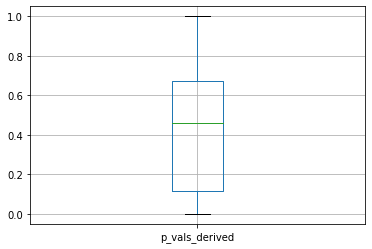

In [161]:
big_kahuna[big_kahuna['p_vals_derived'] != -1].boxplot(column=['p_vals_derived'])

In [162]:
# Make our own stats rows
base = big_kahuna[['study_id', 'measure', 'title', 'measure_param', 'p_vals_derived']]
base['groups'] = pd.Series([[x[0], x[1]] for x in zip(big_kahuna['drug_group_id'].tolist(), big_kahuna['control_group_id'].tolist())])
base['fromStudy'] = pd.Series([False for x in range(len(big_kahuna['drug_group_id'].tolist()))])
base['group_titles'] = pd.Series([dict([x[0], x[1]]) for x in zip(zip(big_kahuna['drug_group_id'].tolist(), big_kahuna['title_y'].tolist()), zip(big_kahuna['control_group_id'].tolist(), big_kahuna['control_title'].tolist()))])
base['method'] = pd.Series(['t-test' for x in range(len(big_kahuna['drug_group_id'].tolist()))])
new_analytics = base.rename(columns={
    'title': 'description',
    'measure_param': 'param_type',
    'p_vals_derived': 'pval'
})
new_analytics

/Users/porterhunley/drugprocessing/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/porterhunley/drugprocessing/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/porterhunley/drugprocessing/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:

,study_id,measure,description,param_type,pval,groups,fromStudy,group_titles,method
0,NCT01922739,Participants With Adverse Events,Any AE,Count of Participants,-1.000000,"[OG001, OG000]",False,{'OG001': 'Hydrocodone ER: Double-Blind Titrat...,t-test
1,NCT01922739,Participants With Adverse Events,Severe AE,Count of Participants,-1.000000,"[OG001, OG000]",False,{'OG001': 'Hydrocodone ER: Double-Blind Titrat...,t-test
2,NCT01922739,Participants With Adverse Events,Treatment-related AE,Count of Participants,-1.000000,"[OG001, OG000]",False,{'OG001': 'Hydrocodone ER: Double-Blind Titrat...,t-test
3,NCT01922739,Participants With Adverse Events,Deaths,Count of Participants,-1.000000,"[OG001, OG000]",False,{'OG001': 'Hydrocodone ER: Double-Blind Titrat...,t-test
4,NCT01922739,Participants With Adverse Events,Serious AE,Count of Participants,-1.000000,"[OG001, OG000]",False,{'OG001': 'Hydrocodone ER: Double-Blind Titrat...,t-test
...,...,...,...,...,...,...,...,...,...
592,NCT01364922,Participant's Global Assessment of Study Drug ...,Fair,Number,-1.000000,"[OG000, OG001]",False,{'OG000': 'Double-blind Hydrocodone/Acetaminop...,t-test
593,NCT01364922,Participant's Global Assessment of Study Drug ...,Poor,Number,-1.000000,"[OG000, OG001]",False,{'OG000': 'Double-blind Hydrocodone/Acetaminop...,t-test
594,NCT00314340,3 Scores on the Addiction Research Center Inve...,trough sedation,Mean,0.570889,"[OG001, OG002]",False,{'OG001': 'Hydrocodone 30 mg Plus N-acetyl-par...,t-test
595,NCT00314340,3 Scores on the Addiction Research Center Inve...,peak euphoria,Mean,0.009696,"[OG001, OG002]",False,{'OG001': 'Hydrocodone 30 mg Plus N-acetyl-par...,t-test


In [163]:
total_analytics = pd.concat([analytics, new_analytics])
# We need a way to figure out the control and intervention groups of the analytics table - merge with the measures??
# That can't be done because the titles are different - I think we need to look at the group titles and use the same 
# function that labels the groups
def get_nested_groups(nested, func):
    for val in nested.values():
        if func(val):
            return val
    return 'NA'
        
total_analytics['intervention_title'] = total_analytics['group_titles'].apply(lambda x: get_nested_groups(x, find_drug_groups))
total_analytics['control_title'] = total_analytics['group_titles'].apply(lambda x: get_nested_groups(x, find_placebo_groups))
total_analytics.head()


,study_id,measure,groups,description,method,param_type,fromStudy,pval,group_titles,intervention_title,control_title
0,NCT01789970,Change From Baseline to Week 12 of the Treatme...,"[OG000, OG001]",The least squares means of the change from bas...,ANCOVA,Mean Difference (Final Values),True,<0.001,{'OG000': 'Placebo (Double-blind Treatment Per...,Hydrocodone ER (Double-blind Treatment Period),Placebo (Double-blind Treatment Period)
1,NCT01789970,Change From Baseline to Week 12 of the Treatme...,"[OG000, OG001]",The least squares means of the change from bas...,ANCOVA,Mean Difference (Final Values),True,<0.001,{'OG000': 'Placebo (Double-blind Treatment Per...,Hydrocodone ER (Double-blind Treatment Period),Placebo (Double-blind Treatment Period)
2,NCT01789970,Kaplan-Meier Estimates for Time to Loss of Eff...,"[OG000, OG001]",NA,Wald chi-square,Hazard Ratio (HR),True,0.059,{'OG000': 'Placebo (Double-blind Treatment Per...,Hydrocodone ER (Double-blind Treatment Period),Placebo (Double-blind Treatment Period)
3,NCT01789970,Percentage of Participants With a 30% or Great...,"[OG000, OG001]",API increase >=30% and API >=5,"Regression, Logistic",Odds Ratio (OR),True,0.0293,{'OG000': 'Placebo (Double-blind Treatment Per...,Hydrocodone ER (Double-blind Treatment Period),Placebo (Double-blind Treatment Period)
4,NCT01789970,Change From Baseline to Final On-Treatment Vis...,"[OG000, OG001]",NA,ANCOVA,Mean Difference (Final Values),True,0.557,{'OG000': 'Placebo (Double-blind Treatment Per...,Hydrocodone ER (Double-blind Treatment Period),Placebo (Double-blind Treatment Period)


#### Aggregates 
- Look at the p-vals from all the primary measures 
- Make sure the measure p-values make sense
- Look at the ranges for all the studies
- Break it down by condition 

In [164]:
measures.head()

,study_id,measure,type,description,dispersion_param,measure_param,units
0,NCT01517295,Peak Plasma Concentration of Hydromorphone,Primary,Determine the plasma pharmacokinetic profile o...,Standard Deviation,Mean,ng/mL
1,NCT01517295,Correlation of Plasma PK of Hydrocodone,Secondary,Correlate the plasma pharmacokinetic profile o...,NA,NA,NA
2,NCT01517295,Peak Urine Concentration of Hydromorphone,Secondary,Analyze the urine concentration of hydromorphone,Standard Deviation,Mean,ng/mL
3,NCT01922739,Participants With Adverse Events,Primary,An adverse event (AE) was defined in the proto...,NA,Count of Participants,Participants
4,NCT01922739,Participants With Potentially Clinically Signi...,Primary,Data represents participants with potentially ...,NA,Count of Participants,Participants


In [165]:
# New table for the aggregates - needs a few things about the measure&study
# type and condition
# This is admitedly bad because it assumes that since the study has pain in a condition, that the 
# measure also involves pain which is wrong
agg = total_analytics.merge(
    measures[['study_id', 'measure', 'type', 'description']], 'left', ['study_id', 'measure']).merge(
    studies_df[['study_id', 'conditions']], 'left', ['study_id']).rename(columns={
    'description_y': 'measure_description', 'description_x': 'description'})
agg['pval'] = agg['pval'].apply(str) # String for regex parsing
agg.head()

,study_id,measure,groups,description,method,param_type,fromStudy,pval,group_titles,intervention_title,control_title,type,measure_description,conditions
0,NCT01789970,Change From Baseline to Week 12 of the Treatme...,"[OG000, OG001]",The least squares means of the change from bas...,ANCOVA,Mean Difference (Final Values),True,<0.001,{'OG000': 'Placebo (Double-blind Treatment Per...,Hydrocodone ER (Double-blind Treatment Period),Placebo (Double-blind Treatment Period),Primary,The WPI was recorded daily by participants in ...,[Low Back Pain]
1,NCT01789970,Change From Baseline to Week 12 of the Treatme...,"[OG000, OG001]",The least squares means of the change from bas...,ANCOVA,Mean Difference (Final Values),True,<0.001,{'OG000': 'Placebo (Double-blind Treatment Per...,Hydrocodone ER (Double-blind Treatment Period),Placebo (Double-blind Treatment Period),Secondary,The API over the last 24 hours was recorded da...,[Low Back Pain]
2,NCT01789970,Kaplan-Meier Estimates for Time to Loss of Eff...,"[OG000, OG001]",NA,Wald chi-square,Hazard Ratio (HR),True,0.059,{'OG000': 'Placebo (Double-blind Treatment Per...,Hydrocodone ER (Double-blind Treatment Period),Placebo (Double-blind Treatment Period),Secondary,Time to loss of efficacy was defined as discon...,[Low Back Pain]
3,NCT01789970,Percentage of Participants With a 30% or Great...,"[OG000, OG001]",API increase >=30% and API >=5,"Regression, Logistic",Odds Ratio (OR),True,0.0293,{'OG000': 'Placebo (Double-blind Treatment Per...,Hydrocodone ER (Double-blind Treatment Period),Placebo (Double-blind Treatment Period),Secondary,The API over the last 24 hours was recorded da...,[Low Back Pain]
4,NCT01789970,Change From Baseline to Final On-Treatment Vis...,"[OG000, OG001]",NA,ANCOVA,Mean Difference (Final Values),True,0.557,{'OG000': 'Placebo (Double-blind Treatment Per...,Hydrocodone ER (Double-blind Treatment Period),Placebo (Double-blind Treatment Period),Secondary,"The RMDQ is a patient-rated, 24-question evalu...",[Low Back Pain]


In [166]:
import re

# This is bad - need to make a distinction between < and > - don't know what to tag '>'
def get_pval_floats(pval):
    try:
        match_range = re.search(r"[<=]", pval)
        greater_match = re.search(r"[>]", pval)
        
        if match_range:
            return float(pval[match_range.start()+1 : len(pval)])
        
        if greater_match:
            return 1
        
        return float(pval)
    except ValueError as e:
        return -2
    return -2

agg['pval_float'] = agg['pval'].apply(get_pval_floats)
# Drop this fucking measure 
agg = agg.drop(agg[agg['pval_float'] > 1].index)
agg['pval_float'].value_counts() # Definitely needs work - still problems with repeats

-1.000000    498
 0.001000    291
-2.000000    131
 0.000100     62
 1.000000     12
            ... 
 0.224300      1
 0.478894      1
 0.001200      1
 0.004700      1
 0.331900      1
Name: pval_float, Length: 908, dtype: int64

In [167]:
agg.head()

,study_id,measure,groups,description,method,param_type,fromStudy,pval,group_titles,intervention_title,control_title,type,measure_description,conditions,pval_float
0,NCT01789970,Change From Baseline to Week 12 of the Treatme...,"[OG000, OG001]",The least squares means of the change from bas...,ANCOVA,Mean Difference (Final Values),True,<0.001,{'OG000': 'Placebo (Double-blind Treatment Per...,Hydrocodone ER (Double-blind Treatment Period),Placebo (Double-blind Treatment Period),Primary,The WPI was recorded daily by participants in ...,[Low Back Pain],0.0010
1,NCT01789970,Change From Baseline to Week 12 of the Treatme...,"[OG000, OG001]",The least squares means of the change from bas...,ANCOVA,Mean Difference (Final Values),True,<0.001,{'OG000': 'Placebo (Double-blind Treatment Per...,Hydrocodone ER (Double-blind Treatment Period),Placebo (Double-blind Treatment Period),Secondary,The API over the last 24 hours was recorded da...,[Low Back Pain],0.0010
2,NCT01789970,Kaplan-Meier Estimates for Time to Loss of Eff...,"[OG000, OG001]",NA,Wald chi-square,Hazard Ratio (HR),True,0.059,{'OG000': 'Placebo (Double-blind Treatment Per...,Hydrocodone ER (Double-blind Treatment Period),Placebo (Double-blind Treatment Period),Secondary,Time to loss of efficacy was defined as discon...,[Low Back Pain],0.0590
3,NCT01789970,Percentage of Participants With a 30% or Great...,"[OG000, OG001]",API increase >=30% and API >=5,"Regression, Logistic",Odds Ratio (OR),True,0.0293,{'OG000': 'Placebo (Double-blind Treatment Per...,Hydrocodone ER (Double-blind Treatment Period),Placebo (Double-blind Treatment Period),Secondary,The API over the last 24 hours was recorded da...,[Low Back Pain],0.0293
4,NCT01789970,Change From Baseline to Final On-Treatment Vis...,"[OG000, OG001]",NA,ANCOVA,Mean Difference (Final Values),True,0.557,{'OG000': 'Placebo (Double-blind Treatment Per...,Hydrocodone ER (Double-blind Treatment Period),Placebo (Double-blind Treatment Period),Secondary,"The RMDQ is a patient-rated, 24-question evalu...",[Low Back Pain],0.5570


In [168]:
agg_minus_dupes = agg.drop_duplicates(['study_id', 'measure', 'description', 'method', 'param_type', 'fromStudy', 'pval', 'type'])
agg_minus_dupes['pval_float'].value_counts()

-1.0000    464
 0.0010    225
 0.0001     58
-2.0000     39
 1.0000     12
          ... 
 0.3525      1
 0.0575      1
 0.6270      1
 0.2009      1
 0.0003      1
Name: pval_float, Length: 908, dtype: int64

<AxesSubplot:>

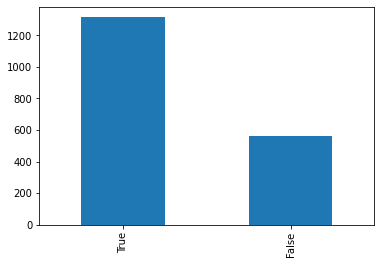

In [169]:
agg_minus_dupes['fromStudy'].value_counts().plot.bar()

<AxesSubplot:>

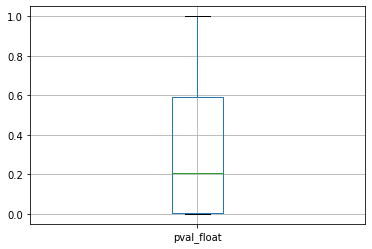

In [170]:
agg_minus_dupes[agg_minus_dupes['pval_float'] > 0].boxplot(column=['pval_float']) # This is starting to look good 




In [171]:
# Let's see what happens if we split off the pain condition
def condition_has_pain(conditions): 
    return True in [('pain' in condition.lower()) for condition in conditions]

agg_minus_dupes['is_pain'] = agg_minus_dupes['conditions'].apply(condition_has_pain)
agg_minus_dupes.head()

/Users/porterhunley/drugprocessing/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,study_id,measure,groups,description,method,param_type,fromStudy,pval,group_titles,intervention_title,control_title,type,measure_description,conditions,pval_float,is_pain
0,NCT01789970,Change From Baseline to Week 12 of the Treatme...,"[OG000, OG001]",The least squares means of the change from bas...,ANCOVA,Mean Difference (Final Values),True,<0.001,{'OG000': 'Placebo (Double-blind Treatment Per...,Hydrocodone ER (Double-blind Treatment Period),Placebo (Double-blind Treatment Period),Primary,The WPI was recorded daily by participants in ...,[Low Back Pain],0.0010,True
1,NCT01789970,Change From Baseline to Week 12 of the Treatme...,"[OG000, OG001]",The least squares means of the change from bas...,ANCOVA,Mean Difference (Final Values),True,<0.001,{'OG000': 'Placebo (Double-blind Treatment Per...,Hydrocodone ER (Double-blind Treatment Period),Placebo (Double-blind Treatment Period),Secondary,The API over the last 24 hours was recorded da...,[Low Back Pain],0.0010,True
2,NCT01789970,Kaplan-Meier Estimates for Time to Loss of Eff...,"[OG000, OG001]",NA,Wald chi-square,Hazard Ratio (HR),True,0.059,{'OG000': 'Placebo (Double-blind Treatment Per...,Hydrocodone ER (Double-blind Treatment Period),Placebo (Double-blind Treatment Period),Secondary,Time to loss of efficacy was defined as discon...,[Low Back Pain],0.0590,True
3,NCT01789970,Percentage of Participants With a 30% or Great...,"[OG000, OG001]",API increase >=30% and API >=5,"Regression, Logistic",Odds Ratio (OR),True,0.0293,{'OG000': 'Placebo (Double-blind Treatment Per...,Hydrocodone ER (Double-blind Treatment Period),Placebo (Double-blind Treatment Period),Secondary,The API over the last 24 hours was recorded da...,[Low Back Pain],0.0293,True
4,NCT01789970,Change From Baseline to Final On-Treatment Vis...,"[OG000, OG001]",NA,ANCOVA,Mean Difference (Final Values),True,0.557,{'OG000': 'Placebo (Double-blind Treatment Per...,Hydrocodone ER (Double-blind Treatment Period),Placebo (Double-blind Treatment Period),Secondary,"The RMDQ is a patient-rated, 24-question evalu...",[Low Back Pain],0.5570,True


In [172]:
pain_agg = agg_minus_dupes[(agg_minus_dupes['is_pain']) & (agg_minus_dupes['pval_float'] > 0) & (agg_minus_dupes['type'] == 'Primary')]
pain_agg

,study_id,measure,groups,description,method,param_type,fromStudy,pval,group_titles,intervention_title,control_title,type,measure_description,conditions,pval_float,is_pain
0,NCT01789970,Change From Baseline to Week 12 of the Treatme...,"[OG000, OG001]",The least squares means of the change from bas...,ANCOVA,Mean Difference (Final Values),True,<0.001,{'OG000': 'Placebo (Double-blind Treatment Per...,Hydrocodone ER (Double-blind Treatment Period),Placebo (Double-blind Treatment Period),Primary,The WPI was recorded daily by participants in ...,[Low Back Pain],0.001000,True
5,NCT01240863,Change From Baseline to Week 12 in Weekly Aver...,"[OG000, OG001]",NA,ANCOVA,Mean Difference (Final Values),True,0.134,{'OG000': 'Placebo (Double-blind Treatment Per...,Hydrocodone ER (Double-blind Treatment Period),Placebo (Double-blind Treatment Period),Primary,The primary efficacy variable was the change f...,[Chronic Pain],0.134000,True
17,NCT02712554,Emax of Drug Liking VAS in Treatment Phase,"[OG002, OG004]",NA,ANOVA,NA,True,<0.0001,"{'OG002': 'Treatment C: M366 22.5 mg/975 mg', ...",NA,Treatment E: Placebo,Primary,Drug liking VAS is the measure of balance of e...,"[Pain, Nausea, Vomiting]",0.000100,True
19,NCT02712554,Emax of Drug Liking VAS in Treatment Phase,"[OG000, OG002]",NA,ANOVA,NA,True,0.2344,{'OG000': 'Treatment A: CL-108 22.5 mg/975 mg/...,NA,NA,Primary,Drug liking VAS is the measure of balance of e...,"[Pain, Nausea, Vomiting]",0.234400,True
20,NCT02712554,Emax of Drug Liking VAS in Treatment Phase,"[OG001, OG003]",NA,ANOVA,NA,True,0.4737,{'OG001': 'Treatment B: CL-108 37.5 mg/1625 mg...,NA,NA,Primary,Drug liking VAS is the measure of balance of e...,"[Pain, Nausea, Vomiting]",0.473700,True
119,NCT01194089,Postoperative Opioid Use During the Postanesth...,"[OG000, OG001]",Comparison between arms for the postoperative ...,Wilcoxon (Mann-Whitney),NA,True,0.828,"{'OG000': 'Nasal Nicotine Spray', 'OG001': 'Na...",NA,NA,Primary,Opioid use was calculated in intravenous morph...,"[Pain, Postoperative]",0.828000,True
120,NCT01194089,Postoperative Opioid Use During the Postanesth...,"[OG000, OG001]",Comparison between the arms for the first 24 h...,Wilcoxon (Mann-Whitney),NA,True,0.752,"{'OG000': 'Nasal Nicotine Spray', 'OG001': 'Na...",NA,NA,Primary,Opioid use was calculated in intravenous morph...,"[Pain, Postoperative]",0.752000,True
129,NCT00315445,"Pain on the Average, Mean Change From Baseline...","[OG000, OG002]",A repeated measures analysis was performed to ...,Mixed Models Analysis,NA,True,0.0350,"{'OG000': 'Placebo', 'OG002': 'BTDS'}",NA,Placebo,Primary,"Subjects were asked, ""Please rate your pain by...",[Back Pain],0.035000,True
130,NCT00315445,"Pain on the Average, Mean Change From Baseline...","[OG000, OG001]",NA,Mixed Models Analysis,NA,True,0.0624,"{'OG000': 'Placebo', 'OG001': 'OXY/APAP'}",NA,Placebo,Primary,"Subjects were asked, ""Please rate your pain by...",[Back Pain],0.062400,True
137,NCT00315445,"Pain Right Now, Mean Change From Baseline, Day...","[OG000, OG002]",A repeated measures analysis was performed to ...,Mixed Models Analysis,NA,True,0.0452,"{'OG000': 'Placebo', 'OG002': 'BTDS'}",NA,Placebo,Primary,"Subjects were asked, ""Please rate your pain by...",[Back Pain],0.045200,True


<AxesSubplot:>

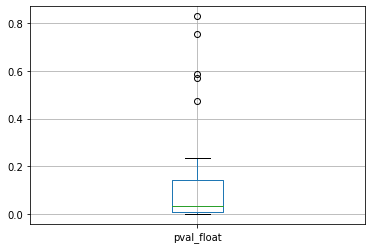

In [173]:
pain_agg.boxplot(column=['pval_float'])

# Looks like this hasn't changed from the aggregates 

<AxesSubplot:xlabel='is_pain', ylabel='pval_float'>

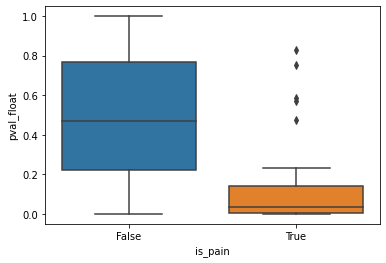

In [174]:
boxie = agg_minus_dupes[(agg_minus_dupes['type'] == 'Primary') & (agg_minus_dupes['pval_float'] > 0)]
sns.boxplot(x='is_pain', y='pval_float', data=boxie)

In [175]:
# A few different things we could look at with these values
# Start looking at what measures are relevant to what condition - this opens up secondary measures 
# Look at the difference between derived and absolute - maybe flag those studies
# Look at the 'purity' of a measure for a drug - see if that measure is only using that drug or something else 
# Start looking at ways to aggregate the doses for analysis
# Start looking at ways to cluster the conditions for similarities
# Start parsing out the side effects 

# I think we need to differentiate between interventions to get purity of a test

In [176]:
# We need the measure description, and both of the groups descriptions

int_aggs = agg_minus_dupes.merge(studies_df[['study_id', 'interventions']], 'left', ['study_id']).rename(columns={
    'interventions':'study_interventions'})
int_aggs.head()

,study_id,measure,groups,description,method,param_type,fromStudy,pval,group_titles,intervention_title,control_title,type,measure_description,conditions,pval_float,is_pain,study_interventions
0,NCT01789970,Change From Baseline to Week 12 of the Treatme...,"[OG000, OG001]",The least squares means of the change from bas...,ANCOVA,Mean Difference (Final Values),True,<0.001,{'OG000': 'Placebo (Double-blind Treatment Per...,Hydrocodone ER (Double-blind Treatment Period),Placebo (Double-blind Treatment Period),Primary,The WPI was recorded daily by participants in ...,[Low Back Pain],0.0010,True,[Hydrocodone]
1,NCT01789970,Change From Baseline to Week 12 of the Treatme...,"[OG000, OG001]",The least squares means of the change from bas...,ANCOVA,Mean Difference (Final Values),True,<0.001,{'OG000': 'Placebo (Double-blind Treatment Per...,Hydrocodone ER (Double-blind Treatment Period),Placebo (Double-blind Treatment Period),Secondary,The API over the last 24 hours was recorded da...,[Low Back Pain],0.0010,True,[Hydrocodone]
2,NCT01789970,Kaplan-Meier Estimates for Time to Loss of Eff...,"[OG000, OG001]",NA,Wald chi-square,Hazard Ratio (HR),True,0.059,{'OG000': 'Placebo (Double-blind Treatment Per...,Hydrocodone ER (Double-blind Treatment Period),Placebo (Double-blind Treatment Period),Secondary,Time to loss of efficacy was defined as discon...,[Low Back Pain],0.0590,True,[Hydrocodone]
3,NCT01789970,Percentage of Participants With a 30% or Great...,"[OG000, OG001]",API increase >=30% and API >=5,"Regression, Logistic",Odds Ratio (OR),True,0.0293,{'OG000': 'Placebo (Double-blind Treatment Per...,Hydrocodone ER (Double-blind Treatment Period),Placebo (Double-blind Treatment Period),Secondary,The API over the last 24 hours was recorded da...,[Low Back Pain],0.0293,True,[Hydrocodone]
4,NCT01789970,Change From Baseline to Final On-Treatment Vis...,"[OG000, OG001]",NA,ANCOVA,Mean Difference (Final Values),True,0.557,{'OG000': 'Placebo (Double-blind Treatment Per...,Hydrocodone ER (Double-blind Treatment Period),Placebo (Double-blind Treatment Period),Secondary,"The RMDQ is a patient-rated, 24-question evalu...",[Low Back Pain],0.5570,True,[Hydrocodone]


In [177]:
# Get number of interventions used 

int_aggs['ints_used'] = int_aggs.apply(lambda x: list(filter(lambda y: y.lower() in x.intervention_title.lower(), x.study_interventions)), axis=1)
int_aggs['no_ints_used'] = int_aggs['ints_used'].apply(len)
int_aggs.head()

,study_id,measure,groups,description,method,param_type,fromStudy,pval,group_titles,intervention_title,control_title,type,measure_description,conditions,pval_float,is_pain,study_interventions,ints_used,no_ints_used
0,NCT01789970,Change From Baseline to Week 12 of the Treatme...,"[OG000, OG001]",The least squares means of the change from bas...,ANCOVA,Mean Difference (Final Values),True,<0.001,{'OG000': 'Placebo (Double-blind Treatment Per...,Hydrocodone ER (Double-blind Treatment Period),Placebo (Double-blind Treatment Period),Primary,The WPI was recorded daily by participants in ...,[Low Back Pain],0.0010,True,[Hydrocodone],[Hydrocodone],1
1,NCT01789970,Change From Baseline to Week 12 of the Treatme...,"[OG000, OG001]",The least squares means of the change from bas...,ANCOVA,Mean Difference (Final Values),True,<0.001,{'OG000': 'Placebo (Double-blind Treatment Per...,Hydrocodone ER (Double-blind Treatment Period),Placebo (Double-blind Treatment Period),Secondary,The API over the last 24 hours was recorded da...,[Low Back Pain],0.0010,True,[Hydrocodone],[Hydrocodone],1
2,NCT01789970,Kaplan-Meier Estimates for Time to Loss of Eff...,"[OG000, OG001]",NA,Wald chi-square,Hazard Ratio (HR),True,0.059,{'OG000': 'Placebo (Double-blind Treatment Per...,Hydrocodone ER (Double-blind Treatment Period),Placebo (Double-blind Treatment Period),Secondary,Time to loss of efficacy was defined as discon...,[Low Back Pain],0.0590,True,[Hydrocodone],[Hydrocodone],1
3,NCT01789970,Percentage of Participants With a 30% or Great...,"[OG000, OG001]",API increase >=30% and API >=5,"Regression, Logistic",Odds Ratio (OR),True,0.0293,{'OG000': 'Placebo (Double-blind Treatment Per...,Hydrocodone ER (Double-blind Treatment Period),Placebo (Double-blind Treatment Period),Secondary,The API over the last 24 hours was recorded da...,[Low Back Pain],0.0293,True,[Hydrocodone],[Hydrocodone],1
4,NCT01789970,Change From Baseline to Final On-Treatment Vis...,"[OG000, OG001]",NA,ANCOVA,Mean Difference (Final Values),True,0.557,{'OG000': 'Placebo (Double-blind Treatment Per...,Hydrocodone ER (Double-blind Treatment Period),Placebo (Double-blind Treatment Period),Secondary,"The RMDQ is a patient-rated, 24-question evalu...",[Low Back Pain],0.5570,True,[Hydrocodone],[Hydrocodone],1


<AxesSubplot:>

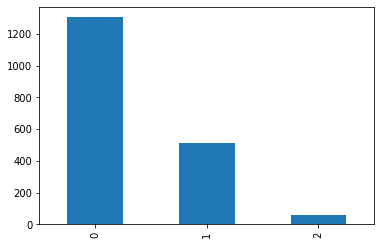

In [178]:
int_aggs['no_ints_used'].value_counts().plot.bar()

In [179]:
int_aggs[int_aggs['no_ints_used'] == 0]

,study_id,measure,groups,description,method,param_type,fromStudy,pval,group_titles,intervention_title,control_title,type,measure_description,conditions,pval_float,is_pain,study_interventions,ints_used,no_ints_used
9,NCT00486902,Number of Subjects Requiring Supplemental Anal...,"[OG000, OG001]",Sample size was determined assuming an inciden...,Fisher Exact,NA,True,0.86,"{'OG000': 'Ketamine', 'OG001': 'Placebo'}",NA,Placebo,Primary,Request for oral hydrocodone/acetaminophen for...,"[Ketamine Adverse Reaction, Effects of; Anesth...",0.86,False,"[Ketamine, N-Methylaspartate]",[],0
10,NCT00486902,Verbal Pain Scores (0 to 10) at First Analgesi...,"[OG000, OG001]",NA,Wilcoxon (Mann-Whitney),NA,True,0.02,"{'OG000': 'Ketamine', 'OG001': 'Placebo'}",NA,Placebo,Secondary,Numeric rating of pain scores (NRS) scale (0 t...,"[Ketamine Adverse Reaction, Effects of; Anesth...",0.02,False,"[Ketamine, N-Methylaspartate]",[],0
11,NCT00486902,Cumulative Hydrocodone/Acetaminophen for Suppl...,"[OG000, OG001]",NA,Wilcoxon (Mann-Whitney),NA,True,0.24,"{'OG000': 'Ketamine', 'OG001': 'Placebo'}",NA,Placebo,Secondary,Cumulative hydrocodone/acetaminophen for suppl...,"[Ketamine Adverse Reaction, Effects of; Anesth...",0.24,False,"[Ketamine, N-Methylaspartate]",[],0
12,NCT00486902,Postoperative Nausea,"[OG000, OG001]",NA,Fisher Exact,NA,True,0.87,"{'OG000': 'Ketamine', 'OG001': 'Placebo'}",NA,Placebo,Secondary,Number of subjects reporting nausea in first 2...,"[Ketamine Adverse Reaction, Effects of; Anesth...",0.87,False,"[Ketamine, N-Methylaspartate]",[],0
13,NCT00486902,Postoperative Vomiting,"[OG000, OG001]",NA,Fisher Exact,NA,True,0.90,"{'OG000': 'Ketamine', 'OG001': 'Placebo'}",NA,Placebo,Secondary,Number of subjects that vomited in the first 2...,"[Ketamine Adverse Reaction, Effects of; Anesth...",0.90,False,"[Ketamine, N-Methylaspartate]",[],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1309,NCT01753518,Cosmetic Outcome,"[OG000, OG001]",Comparison between arms for observer: thickness,Wilcoxon (Mann-Whitney),NA,True,0.75,"{'OG000': 'Subcuticular Suture', 'OG001': 'Sub...",NA,NA,Secondary,The cosmetic outcome will be assessed by patie...,[Surgical Wound],0.75,False,[],[],0
1310,NCT01753518,Cosmetic Outcome,"[OG000, OG001]",Comparison between arms for observer: relief.,Wilcoxon (Mann-Whitney),NA,True,0.36,"{'OG000': 'Subcuticular Suture', 'OG001': 'Sub...",NA,NA,Secondary,The cosmetic outcome will be assessed by patie...,[Surgical Wound],0.36,False,[],[],0
1311,NCT01753518,Cosmetic Outcome,"[OG000, OG001]",Comparison between arms for observer: pliability.,Wilcoxon (Mann-Whitney),NA,True,0.78,"{'OG000': 'Subcuticular Suture', 'OG001': 'Sub...",NA,NA,Secondary,The cosmetic outcome will be assessed by patie...,[Surgical Wound],0.78,False,[],[],0
1312,NCT01753518,Cosmetic Outcome,"[OG000, OG001]",Comparison between arms for observer: surface ...,Wilcoxon (Mann-Whitney),NA,True,0.76,"{'OG000': 'Subcuticular Suture', 'OG001': 'Sub...",NA,NA,Secondary,The cosmetic outcome will be assessed by patie...,[Surgical Wound],0.76,False,[],[],0


Currently looking at about a 20% hit rate for analytics coming from the studies themsevles
This is not good at all considering these are generally assumed to be more accurate though 
they do measure more things than just one drug so high attrition is to be expected

- Note: Over half of those are coming from two studies with no interventions at all so it's not as bas as it seems

<AxesSubplot:>

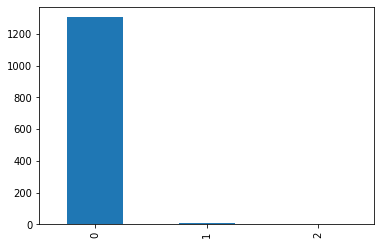

In [180]:
int_aggs[int_aggs['fromStudy']]['no_ints_used'].value_counts().plot.bar()

<AxesSubplot:>

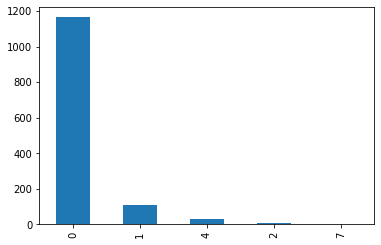

In [181]:
int_aggs[int_aggs['fromStudy']]['study_interventions'].apply(len).value_counts().plot.bar()

# How can a study have 0 interventions???

In [182]:
int_aggs[int_aggs['study_interventions'].apply(len) == 0]['study_id'].value_counts()

NCT03975790    665
NCT01931670    188
NCT01620528    180
NCT02712554     99
NCT01753518     33
Name: study_id, dtype: int64

<AxesSubplot:xlabel='no_ints_used', ylabel='pval_float'>

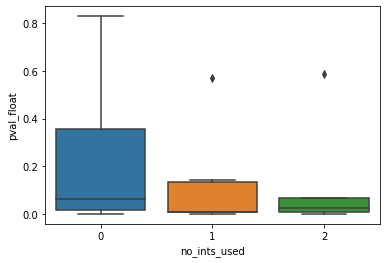

In [183]:
# Let's redo the pain stuff with boxplots
pain_agg = int_aggs[int_aggs['is_pain'] & (int_aggs['pval_float'] > 0) & (int_aggs['type'] == 'Primary')]
sns.boxplot(x='no_ints_used', y='pval_float', data=pain_agg)

Let's see if we can get some decent results this way - only using primaries

- Secondaries should be labeled for this kind of thing to, but our false positive rate is low which is what matters
- Still need to deal with that greater than issue


In [184]:
# Need to break off a few conditions - let's manually group them for now - just take the first one
studies_df['conditions'].apply(lambda x: x[0]).value_counts()[0:10]

Pain                     9
Endometriosis            5
Chronic Pain             5
Chronic Low Back Pain    4
Low Back Pain            3
Breast Cancer            2
Postoperative Pain       2
Opioid Use               2
Pain, Postoperative      2
Driving Behavior         1
Name: conditions, dtype: int64

In [185]:
int_aggs['conditions'].apply(lambda x: x[0]).value_counts()

Rheumatoid Arthritis                665
Chronic Pain                        444
Endometriosis                       368
Pain                                211
Low Back Pain                        54
Surgical Wound                       33
Postoperative Dental Pain            32
Back Pain                            26
Chronic Low Back Pain                22
Ketamine Adverse Reaction             8
Pain, Postoperative                   7
Malignant Head and Neck Neoplasm      3
Carpal Tunnel                         2
Opioid Use                            1
Back Pain Lower Back Chronic          1
Name: conditions, dtype: int64

In [186]:
int_aggs['study_id'].value_counts()

NCT03975790    665
NCT01240863    441
NCT01931670    188
NCT01620528    180
NCT02712554     99
NCT01266161     64
NCT01789970     48
NCT01753518     33
NCT01529346     32
NCT01038609     27
NCT00315445     26
NCT01364922     11
NCT00935311     11
NCT01452529     11
NCT00486902      8
NCT01194089      7
NCT01922739      6
NCT01330459      5
NCT01333722      5
NCT00314340      3
NCT02480114      3
NCT02029235      2
NCT01081912      1
NCT03372382      1
Name: study_id, dtype: int64

## Side Affects
Take a look at the adverse affects from each study - this is where drug purity comes in though

Should we just sum up all the adverse affects or only those with the drug in them

#### Data Model
- Need to make the tables first 

In [187]:
groups.head()

,name,study_id,id,description,participants
0,Group 1,NCT01517295,BG000,"Blood will be drawn at 0, 1, 3, and 5 hours af...",16
1,Group 2,NCT01517295,BG001,"Blood will be drawn at 0, 2, 4, and 6 hours af...",14
2,Total,NCT01517295,BG002,Total of all reporting groups,30
3,Hydrocodone ER - Opioid Naive,NCT01922739,BG000,Participants were administered hydrocodone ER ...,109
4,Hydrocodone ER - Opioid Experienced,NCT01922739,BG001,Participants were administered hydrocodone ER ...,73


In [188]:
# We need to add the event groups to the groups table??
def add_effects_groups(studies):
    df = {
        'study_id': [],
        'id': [],
        'name': [],
        'description': [],
        'participants': []
    }
    for i, study in enumerate(studies):
        study_id = study['Study']['ProtocolSection']['IdentificationModule']['NCTId']
        adverse_module = study['Study']['ResultsSection']['AdverseEventsModule'] #Small risk here
        for group in adverse_module.get('EventGroupList', {'EventGroup': []})['EventGroup']:
            df['study_id'].append(study_id)
            df['id'].append(group.get('EventGroupId', 'NA'))
            df['name'].append(group.get('EventGroupTitle', 'NA'))
            df['description'].append(group.get('EventGroupDescription', 'NA'))
            df['participants'].append(int(group.get('EventGroupOtherNumAtRisk', 0) or group.get('EventGroupDeathsNumAtRisk', 0) or group.get('EventGroupSeriousNumAtRisk', 0)))
    
    return df

total_groups = pd.concat([groups, pd.DataFrame.from_dict(add_effects_groups(studies))])
total_groups.head()

,name,study_id,id,description,participants
0,Group 1,NCT01517295,BG000,"Blood will be drawn at 0, 1, 3, and 5 hours af...",16
1,Group 2,NCT01517295,BG001,"Blood will be drawn at 0, 2, 4, and 6 hours af...",14
2,Total,NCT01517295,BG002,Total of all reporting groups,30
3,Hydrocodone ER - Opioid Naive,NCT01922739,BG000,Participants were administered hydrocodone ER ...,109
4,Hydrocodone ER - Opioid Experienced,NCT01922739,BG001,Participants were administered hydrocodone ER ...,73


In [189]:
def create_effects_table(studies):
    df = {
        'drug': [],
        'study_id': [],
        'group_id': [],
        'effect_name': [],
        'type': [], #Serious or other
        'organ_system': [],
        'assesment': [],
        'no_effected': [],
        'collection_threshold': []
    }
    for i, study in enumerate(studies):
        study_id = study['Study']['ProtocolSection']['IdentificationModule']['NCTId']
        adverse_module = study['Study']['ResultsSection']['AdverseEventsModule'] #Small risk here
        for event in adverse_module.get('OtherEventList', {'OtherEvent': []})['OtherEvent']:
            for stat in event.get('OtherEventStatsList', {'OtherEventStats': []})['OtherEventStats']:
                df['drug'].append(EXAMPLE_DRUG)
                df['study_id'].append(study_id)
                df['group_id'].append(stat.get('OtherEventStatsGroupId', 'NA'))
                df['effect_name'].append(event.get('OtherEventTerm', 'NA'))
                df['type'].append('other')
                df['organ_system'].append(event.get('OtherEventOrganSystem', 'NA'))
                df['assesment'].append(event.get('OtherEventAssessmentType', 'NA'))
                df['no_effected'].append(float(stat.get('OtherEventStatsNumAffected', 0)) or float(stat.get('OtherEventStatsNumEvents', 0)))
                df['collection_threshold'].append(float(adverse_module.get('EventsFrequencyThreshold', -1)))
    return df

effects = pd.DataFrame.from_dict(create_effects_table(studies))
effects       

,drug,study_id,group_id,effect_name,type,organ_system,assesment,no_effected,collection_threshold
0,hydrocodone,NCT01922739,EG000,Constipation,other,Gastrointestinal disorders,Systematic Assessment,9.0,5.0
1,hydrocodone,NCT01922739,EG001,Constipation,other,Gastrointestinal disorders,Systematic Assessment,12.0,5.0
2,hydrocodone,NCT01922739,EG000,Nausea,other,Gastrointestinal disorders,Systematic Assessment,19.0,5.0
3,hydrocodone,NCT01922739,EG001,Nausea,other,Gastrointestinal disorders,Systematic Assessment,10.0,5.0
4,hydrocodone,NCT01223365,EG000,Constipation,other,Gastrointestinal disorders,Systematic Assessment,19.0,5.0
...,...,...,...,...,...,...,...,...,...
1684,hydrocodone,NCT01179191,EG000,Rash generalised,other,Skin and subcutaneous tissue disorders,Non-systematic Assessment,1.0,0.0
1685,hydrocodone,NCT01179191,EG000,Swelling face,other,Skin and subcutaneous tissue disorders,Non-systematic Assessment,1.0,0.0
1686,hydrocodone,NCT01179191,EG000,Deep vein thrombosis,other,Vascular disorders,Non-systematic Assessment,1.0,0.0
1687,hydrocodone,NCT01179191,EG000,Hypertension,other,Vascular disorders,Non-systematic Assessment,1.0,0.0


#### Explore Effects
Let's take a look into this brand new world just discovered

In [190]:
# The top few are expected for this drug

effects['effect_name'].value_counts()

Nausea                74
Headache              66
Dizziness             62
Vomiting              57
Constipation          53
                      ..
Presyncope             1
Gastritis              1
Anaemia                1
Aggression             1
Emotional disorder     1
Name: effect_name, Length: 321, dtype: int64

#### Compare to Controls
Let's label which effects came from the drug versus the control to get a good idea

In [191]:
working_effects = effects.merge(total_groups.rename(columns={'id': 'group_id'}), 'left', ['study_id', 'group_id'])
working_effects['is_control'] = working_effects['name'].apply(find_placebo_groups)
working_effects['is_intervention'] = working_effects['name'].apply(find_drug_groups)
working_effects

,drug,study_id,group_id,effect_name,type,organ_system,assesment,no_effected,collection_threshold,name,description,participants,is_control,is_intervention
0,hydrocodone,NCT01922739,EG000,Constipation,other,Gastrointestinal disorders,Systematic Assessment,9.0,5.0,Hydrocodone ER - Titration/Adjustment Period,Participants were administered hydrocodone ER ...,182,False,True
1,hydrocodone,NCT01922739,EG001,Constipation,other,Gastrointestinal disorders,Systematic Assessment,12.0,5.0,Hydrocodone ER - Open-Label Treatment Period,Participants were administered hydrocodone ER ...,170,False,True
2,hydrocodone,NCT01922739,EG000,Nausea,other,Gastrointestinal disorders,Systematic Assessment,19.0,5.0,Hydrocodone ER - Titration/Adjustment Period,Participants were administered hydrocodone ER ...,182,False,True
3,hydrocodone,NCT01922739,EG001,Nausea,other,Gastrointestinal disorders,Systematic Assessment,10.0,5.0,Hydrocodone ER - Open-Label Treatment Period,Participants were administered hydrocodone ER ...,170,False,True
4,hydrocodone,NCT01223365,EG000,Constipation,other,Gastrointestinal disorders,Systematic Assessment,19.0,5.0,New Opioid Naïve Subpopulation,The subpopulation of participants who enrolled...,52,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1684,hydrocodone,NCT01179191,EG000,Rash generalised,other,Skin and subcutaneous tissue disorders,Non-systematic Assessment,1.0,0.0,EMBEDA,EMBEDA (morphine sulfate/naltrexone hydrochlor...,684,False,False
1685,hydrocodone,NCT01179191,EG000,Swelling face,other,Skin and subcutaneous tissue disorders,Non-systematic Assessment,1.0,0.0,EMBEDA,EMBEDA (morphine sulfate/naltrexone hydrochlor...,684,False,False
1686,hydrocodone,NCT01179191,EG000,Deep vein thrombosis,other,Vascular disorders,Non-systematic Assessment,1.0,0.0,EMBEDA,EMBEDA (morphine sulfate/naltrexone hydrochlor...,684,False,False
1687,hydrocodone,NCT01179191,EG000,Hypertension,other,Vascular disorders,Non-systematic Assessment,1.0,0.0,EMBEDA,EMBEDA (morphine sulfate/naltrexone hydrochlor...,684,False,False


In [192]:
int_sums = {}
def count_effects(effect_name, no_affected, ledger):
    if effect_name not in ledger:
        ledger[effect_name] = 0
    ledger[effect_name] += no_affected

intervention_effects = working_effects[working_effects['is_intervention']]

intervention_effects.apply(lambda x: count_effects(x.effect_name, x.no_effected, int_sums), axis=1)
int_effect_sums = pd.Series(int_sums).sort_values(ascending=False)
int_effect_sums

Nausea                                  432.0
Constipation                            331.0
Vomiting                                176.0
Headache                                171.0
Dizziness                               156.0
Somnolence                               91.0
NAUSEA                                   64.0
Drowsiness                               52.0
CONSTIPATION                             38.0
DIZZINESS                                36.0
Pruritus                                 30.0
HEADACHE                                 24.0
SOMNOLENCE                               22.0
VOMITING                                 17.0
somnolence                               13.0
constipation                             13.0
PRURITUS                                 11.0
Upper respiratory tract infection        11.0
Urinary Tract Infection                   8.0
Back Pain                                 6.0
Hypoacusis                                5.0
CELLULITIS                        

In [193]:
# Now the controls 
cont_sums = {}
working_effects[working_effects['is_control']].apply(lambda x: count_effects(x.effect_name, x.no_effected, cont_sums), axis=1)
cont_effect_sums = pd.Series(cont_sums).sort_values(ascending=False)
cont_effect_sums

HEADACHE                   130.0
NAUSEA                     120.0
Nausea                      71.0
HOT FLUSH                   63.0
URINARY TRACT INFECTION     62.0
                           ...  
Vision Blurred               0.0
Light-headed                 0.0
Photophobia                  0.0
Hyperhidrosis                0.0
Hot Flush                    0.0
Length: 100, dtype: float64

<AxesSubplot:>

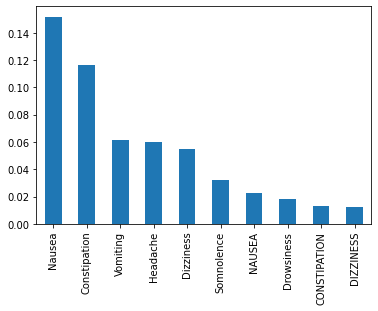

In [194]:
# Get the percentages 
total_at_risk = working_effects[working_effects['is_intervention']].drop_duplicates(['study_id'])['participants'].sum()
percent_effects = {k: (v/total_at_risk) for (k,v) in int_sums.items()}
pd.Series(percent_effects).sort_values(ascending=False)[0:10].plot.bar()


### Clustering 
There are a lot of similar conditions and side effects that should be considered as one

Not expercting a full blown system or model as might be reuqired, but maybe some basic edit distance clustering 
would help

We could also take a look wordnet to find synonyms here - might be better than a medical dictionary, though wordnet might be quite large 

Perhaps removing the adjectives in the conditions would help as well - jsut get the noun

In [203]:
# Edit distance implementation: https://stackoverflow.com/questions/2460177/edit-distance-in-python

def levenshteinDistance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

In [ ]:
# Cluster by distance to see what similar means 
# We will try: heirarchical, affinity, and maybe some graph based 
# First heirarchical 


In [ ]:
# This looks good but a decent amount of these side effects are the same or synonyms
# I think we can run a edit distance on some of these

def medical_similarity(wordA, wordB):
    raw_distance = levenshteinDistance(wordA, wordB)
    
    

In [195]:
from nltk.corpus import wordnet as wn

In [201]:
wn.synsets('somnolence')

[Synset('sleepiness.n.01')]

In [202]:
wn.synsets('drowsiness')

[Synset('sleepiness.n.01')]